## General Processing

Workflow:
1. General filter
2. Outliers detection
3. Train and test set splitting
4. Missing values imputation
5. Add Score values
6. Output the train and test data




### Load master dataset

In [53]:
import pandas as pd
import os
from helpers6 import *
from sklearn.impute import SimpleImputer

In [54]:
# Just place the dataset in the same folder as the notebook
df = pd.read_csv('master_dataset_2.csv')

### 1. General filter - Drop all unused Features

#### Filter out pedaetrics and missing acuity

In [55]:
# Usually medical treatments are different for pedaetric and adult patients.
df = df[df['age'] >= 18]

In [56]:
df = df[df['triage_acuity'].notnull()]

    This Chunk is to identify the rows with same hospitalisation entries on different ed entries. (Josepth Highlighted this issue) About 1126 rows. As A quick hack we can either drop it totally or retain only the last entry for each hospitalisation. this code is now only for reference. an extra line would need to be coded in to filter out the duplicates. to be discussed on Sat

In [97]:
# # count number of null values in hadm_id
# df['hadm_id'].isnull().sum()

# # drop all entries with null in hadm_id and put into df_duplicates
# df_no_null = df.dropna(subset=['hadm_id'])

# # # identify duplicate rows in df on hadm_id
# # df_no_null_no_duplicates = df_no_null.drop_duplicates(subset=['hadm_id'], keep = False)

# # Identify duplicates based on 'hadm_id'
# duplicates_mask = df_no_null.duplicated(subset=['hadm_id'], keep=False)

# # Use boolean indexing to filter the DataFrame
# df_result = df_no_null[duplicates_mask | ~duplicates_mask.duplicated(keep='first')]

# # ouput the duplicate rows to csv
# df_result.to_csv('duplicate_hospitalisations.csv')

#### Drop features that are not used

In [57]:
# drop features deemeed unnecessary
df = df.drop(['index', 'subject_id', 'hadm_id', 'stay_id', 'anchor_age', 'anchor_year', 'dod',
                            'admittime', 'dischtime', 'deathtime', 'race', 'edregtime', 'edouttime', 'in_year',
                            'before_ed_mortality', 'ed_los', 'intime_icu', 'outtime_icu', 'time_to_icu_transfer', 'time_to_icu_transfer_hours',
                           'next_ed_visit_time', 'next_ed_visit_time_diff', 'next_ed_visit_time_diff_days', 'chiefcomplaint'], axis=1)

In [58]:
# Check current shape of df
df.shape

(440786, 96)

In [ ]:
#add-in upsample

outcome_ed_revisit_3d
False    425521
True      15265
Name: count, dtype: int64


<Axes: ylabel='Type'>

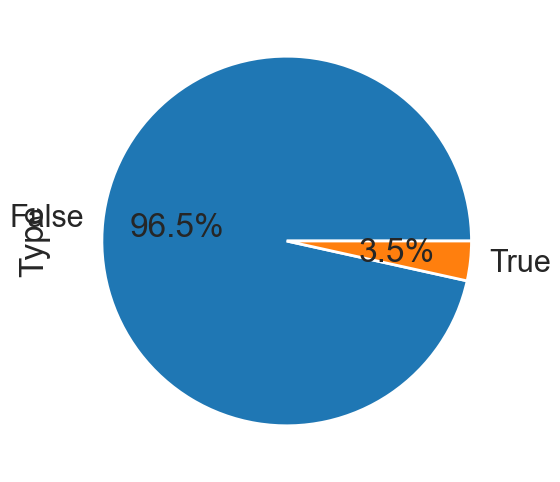

In [59]:
from sklearn.utils import resample

df_minority = df[df["outcome_ed_revisit_3d"]==True]
df_majority = df[df["outcome_ed_revisit_3d"]==False]
# upsample to make number of minority to 30% of majority
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=round(440000*0.3))
#output of  distribution
print(df["outcome_ed_revisit_3d"].value_counts())

df.groupby('outcome_ed_revisit_3d').size().plot(kind='pie',
                                       y = "outcome_ed_revisit_3d",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [68]:
# Combine majority class with upsampled minority class
df_up_sampled = pd.concat([df_majority, df_minority_upsampled])

<Axes: ylabel='Type'>

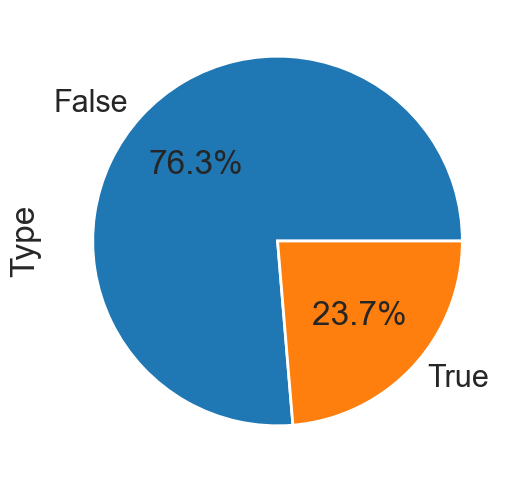

In [69]:
df_up_sampled.groupby('outcome_ed_revisit_3d').size().plot(kind='pie',
                                       y = "outcome_ed_revisit_3d",
                                       label = "Type",
                                       autopct='%1.1f%%')

### 2. Outlier Detection

In [78]:
# from mimic-extract
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high':47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high':390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high':330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high':150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high':10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high':5},
}

In [79]:
df = convert_temp_to_celcius(df_up_sampled)

In [82]:
df = remove_outliers(df, vitals_valid_range)
# what this really does is to transform values between valid low and outlier low to valid low,
# and values between valid high and outlier high to valid high
# anything beyond outlier low and outlier high will be set to NaN
# however the code later imputes NaN with median. i have some concerns with this and would prefer to drop the rows with NaN
# (it's approximately 12k rows only anyway)

In [83]:
# check shape of df
df.shape

(557521, 96)

### 3. Data Manipulation for ML

In [84]:
# Change True and False to Binary 1 and 0
df = df.replace(True, 1)
df = df.replace(False, 0)

In [85]:
# one-hot encode Insurance Type
df = pd.get_dummies(df, columns=['insurance'])

In [86]:
# view columns
df.columns

Index(['intime_ed', 'outtime_ed', 'gender', 'age', 'outcome_hospitalization',
       'outcome_inhospital_mortality', 'ed_death', 'outcome_icu_transfer_12h',
       'outcome_critical', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d',
       'outcome_ed_revisit_3d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d',
       'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'ed_los_hours',
       'triage_temperature', 'triage_heartrate', 'triage_resprate',
       'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain',
       'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain',
       'chiefcom_headache', 'chiefcom_shortness_of_breath',
       'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting',
       'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness',
       'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia',
       'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1',
       'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2',
 

In [87]:
# Check Shape
df.shape

(557521, 98)

In [88]:
# Check for Null Values
df.isna().sum()[df.isna().sum() > 0]

triage_temperature     21333
triage_heartrate       12629
triage_resprate        16896
triage_o2sat           17429
triage_sbp             14346
triage_dbp             15942
triage_pain            43866
ed_temperature_last    32799
ed_heartrate_last      22334
ed_resprate_last       22927
ed_o2sat_last          36877
ed_sbp_last            22639
ed_dbp_last            23003
ed_pain_last           63241
dtype: int64

### 4. Option B: Drop NaNs

In [89]:
df.shape

(557521, 98)

In [90]:
# drop all rows with nan values
df_drop = df.dropna()
df_drop.shape

(429527, 98)

### 5. Option B: Add Score values

In [91]:
add_triage_MAP(df_drop) # add an extra variable MAP
add_score_CCI(df_drop)
add_score_CART(df_drop)
add_score_REMS(df_drop)
add_score_NEWS(df_drop)
add_score_NEWS2(df_drop)
add_score_MEWS(df_drop)

Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_MEWS' successfully added


/Users/chenyiman/Documents/July23term/healthcareanalytics/Project/TASK3_DROP/helpers6.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['triage_MAP'] = df['triage_sbp']*1/3 + df['triage_dbp']*2/3
/Users/chenyiman/Documents/July23term/healthcareanalytics/Project/TASK3_DROP/helpers6.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_CCI'] = np.select(conditions, values)
/Users/chenyiman/Documents/July23term/healthcareanalytics/Project/TASK3_DROP/helpers6.py:468: SettingWithCopyWarning: 
A 

In [92]:
df_drop.shape

(429527, 105)

### 6. Option B: Split Train (80%) and Test (20%) data

In [93]:
# Split Train and Test data
df_train_drop=df_drop.sample(frac=0.8,random_state=2023) #random state is a seed value
df_test_drop=df_drop.drop(df_train_drop.index)

In [94]:
print(df_train_drop.shape)
print(df_test_drop.shape)

(343622, 105)
(65921, 105)


### 7. Option B: Output the train and test data

In [95]:
df_train_drop.to_csv('train_drop.csv', index=False)
df_test_drop.to_csv('test_drop.csv', index=False)